In [1]:
from binance.spot import Spot 
from sys import stderr
import sys, os,datetime,requests,json,pandas as pd,numpy as np
import time,math, gc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.model_selection import train_test_split
min_max_scaler = sklearn.preprocessing.MinMaxScaler()



import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def import_api(time_last,symbol="BTCUSDT",limit=12*60):
    params={"symbol":symbol,"limit":limit,"interval":"1m","endTime":time_last,"startTime":(time_last-12*3600*1000)}
    r=requests.get(url="https://api.binance.com/api/v3/klines", params=params)
    df=pd.DataFrame(r.json())
    return df

def transform_df (df):
    column_names=['Open_time','Open','High','Low','Close','Volume','Close_time','Quote_asset_volume',
               'Number_of_trades','Taker_buy_base_asset_volume','Taker_buy_quote_asset_volume','Ignore']
    df=df.reset_index(drop=True)
    df.set_axis(column_names,axis=1,inplace=True)
    for col in df.columns:
        df[col] = df[col].astype(float)
    weekday=[]
    month=[]
    for i in range(df['Open'].size):
        dt_open=datetime.datetime.fromtimestamp(df['Open_time'][i]//1000)
        dt_close=datetime.datetime.fromtimestamp(df['Close_time'][i]//1000)
        df['Open_time'][i]=dt_open.hour*3600+dt_open.minute*60+dt_open.second
        df['Close_time'][i]=dt_close.hour*3600+dt_close.minute*60+dt_close.second
        weekday.append(dt_open.weekday())
        month.append(dt_open.month)
        #df['Open_time'][i]=dt_open.strftime("%I:%M:%S")
        #df['Close_time'][i]=dt_close.strftime("%I:%M:%S")
    df['weekday']=weekday
    df['month']=month
    df=df.drop(df.columns[[7,10,11,13]],axis=1)
    del(month)
    del(weekday)
    return df


def moving_average(data,range_,concat=60):
    leftover=len(data)%concat
    data=data[::concat].reset_index(drop=True)
    mean=[]
    arr=[]
    for i in range(range_):
        this_mean=0
        for j in range(i+1):
            this_mean+=data[j]
        mean.append(this_mean/(j+1))
    if leftover:
        data_size=len(data)-1
    else:
        data_size=len(data)
    for i in range(range_,data_size):
        this_mean=data[i]
        for j in range(1,range_):
            this_mean+=data[i-j]
        mean.append(this_mean/(range_))
    arr=leftover*[mean[0]]
    for i in range(len(mean)):
        arr+=concat*[mean[i]]
    
    
    return arr

def generate_previous(df,count,col_name):
    #idxes=
    df=df.reset_index(drop=True)
    values=list(df[col_name][0:count])
    columns={}
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        columns[this_name]=[]
    for i in range(count,df[col_name].size):
        for j in range(count):
            this_name="prev_"+col_name+"_"+str(j+1)
            columns[this_name].append(values[-(j+1)])
        values.pop(0)
        values.append(df[col_name][i])
    size=df[col_name].size
    df=df[count:size]
    for i in range(count):
        this_name="prev_"+col_name+"_"+str(i+1)
        df[this_name]=columns[this_name]
    
    return df.reset_index(drop=True)

def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in (df.iloc[i:i+window_size].drop("target",axis=1).values)]
        X.append(row)
        label = df["target"][i+window_size-1]
        y.append(label)
    return np.array(X), np.array(y)

def preprocess_df(df,target_range,hours,hours_interval,days,days_interval,scaling_range=0.2):
    target=[]
    concat_hours=3
    concat_days=8
    window=target_range
    for i in range(df["Open"].size-window):
        target.append(df["Open"][i+window])
    df=df[0:df["Open"].size-window]
    df["target"]=target
    df=df.drop(["Close_time","Taker_buy_base_asset_volume","Volume","Close","Low","High","Number_of_trades"],axis=1)
    for i in range(1,hours//hours_interval+1):
        df["mean_"+str(i*hours_interval)+"_hours"]=moving_average(df["Open"],i*(12//concat_hours)*hours_interval,concat_hours)
    for i in range(1,days//days_interval+1):
        df["mean_"+str(i*days_interval)+"_days"]=moving_average(df["Open"],i*12*(24//concat_days)*days_interval,concat_days)
    drop_col=["Open",'Open_time','weekday']
    open_delta=[]
    df["weekday"]=df["weekday"].astype(float)
    for col in df.drop(drop_col,axis=1).columns:
        for i in range(df["Open"].size):
            df[col][i]=df[col][i]/df["Open"][i]
    for i in range(1,df["Open"].size):
        df["Open_time"][i]/=86400
        df["weekday"][i]/=6.0
        delta=df["Open"][i]-df["Open"][i-1]
        open_delta.append(delta/df["Open"][i])
    df=df.drop(0,axis=0)
    cols=df.columns[3:]
    for i in cols:
        for j in range(1,df["Open"].size):
            df[i][j]=(df[i][j]-(1-scaling_range))/(scaling_range*2)
    return df

def upscale(input_data,scaling_range):
    return input_data*2*scaling_range-scaling_range+1

In [ ]:
directory="G:\Учеба\биржа"

In [3]:
df=pd.read_csv(directory+'\\eth_usdt_5min.csv').reset_index(drop=True)
df=preprocess_df(df,4,24,1,15,1)

C:\Users\DANIEL~1\AppData\Local\Temp/ipykernel_9780/1157910730.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"]=target


In [4]:
df

,Open_time,Open,weekday,target,mean_1_hours,mean_2_hours,mean_3_hours,mean_4_hours,mean_5_hours,mean_6_hours,...,mean_6_days,mean_7_days,mean_8_days,mean_9_days,mean_10_days,mean_11_days,mean_12_days,mean_13_days,mean_14_days,mean_15_days
1,0.482639,3919.13,0.500000,0.444975,0.500772,0.500772,0.500772,0.500772,0.500772,0.500772,...,0.500772,0.500772,0.500772,0.500772,0.500772,0.500772,0.500772,0.500772,0.500772,0.500772
2,0.486111,3910.77,0.500000,0.447766,0.506118,0.506118,0.506118,0.506118,0.506118,0.506118,...,0.506118,0.506118,0.506118,0.506118,0.506118,0.506118,0.506118,0.506118,0.506118,0.506118
3,0.489583,3878.60,0.500000,0.480728,0.526904,0.526904,0.526904,0.526904,0.526904,0.526904,...,0.526904,0.526904,0.526904,0.526904,0.526904,0.526904,0.526904,0.526904,0.526904,0.526904
4,0.493056,3869.55,0.500000,0.488080,0.532814,0.532814,0.532814,0.532814,0.532814,0.532814,...,0.532814,0.532814,0.532814,0.532814,0.532814,0.532814,0.532814,0.532814,0.532814,0.532814
5,0.496528,3832.87,0.500000,0.481522,0.543440,0.543440,0.543440,0.543440,0.543440,0.543440,...,0.557053,0.557053,0.557053,0.557053,0.557053,0.557053,0.557053,0.557053,0.557053,0.557053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105033,0.447917,2070.55,0.666667,0.489097,0.528136,0.539214,0.538399,0.535211,0.529537,0.516679,...,0.824131,0.884462,0.946661,1.007834,1.046077,1.080020,1.105423,1.125922,1.147639,1.173237
105034,0.451389,2059.36,0.666667,0.499490,0.541873,0.553011,0.552192,0.548987,0.543282,0.530354,...,0.839477,0.900135,0.962672,1.024177,1.062629,1.096756,1.122297,1.142908,1.164742,1.190479
105035,0.454861,2057.97,0.666667,0.506851,0.532347,0.545927,0.552932,0.548986,0.545993,0.535235,...,0.841395,0.902094,0.964673,1.026220,1.064697,1.098848,1.124405,1.145030,1.166880,1.192634
105036,0.458333,2048.17,0.666667,0.520433,0.544463,0.558108,0.565148,0.561183,0.558174,0.547366,...,0.854990,0.915980,0.978858,1.040700,1.079361,1.113675,1.139355,1.160079,1.182032,1.207910


In [5]:
#difference=[]
#for i in range(df["Open"].size):
#    difference.append(abs(df["Open"][i]-df["target"][i]))
#pd.DataFrame(difference).describe()

In [6]:
df=df.drop(["Open","target"],axis=1).to_numpy()

In [7]:
df.shape

(85037, 41)

In [7]:
class Net(nn.Module):
    def __init__(self,drop,input_size,hidden_size,test_size):
        super(Net, self).__init__()
        self.norm=nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc3 = nn.Linear(hidden_size, test_size,bias=True)
        self.fc4 = nn.Linear(test_size, hidden_size,bias=True)
        self.fc5 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc6 = nn.Linear(hidden_size, hidden_size,bias=True)
        self.fc7 = nn.Linear(hidden_size, input_size,bias=True)
        self.dropout = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(F.relu(x))
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = self.dropout(F.relu(x))
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        return x
    def encode (self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x

In [9]:
from sklearn.utils import shuffle
arr=list(range(20))
shuffle(arr,random_state=2)

[12, 4, 18, 0, 9, 5, 3, 10, 1, 17, 7, 16, 14, 2, 11, 6, 19, 13, 15, 8]

In [10]:
device

device(type='cuda', index=0)

In [11]:
test_size=0.1
X_train=shuffle(df,random_state=2)
X_size=X_train.shape[0]
X_test=X_train[int(X_size*(1-test_size)):]
X_train=X_train[:int(X_size*(1-test_size))]
X_train=torch.tensor(X_train,device="cuda")
X_test=torch.tensor(X_test,device="cuda")

In [12]:
#encoder=Net(500,8).to(device).double()

In [13]:
#a=encoder(torch.tensor(X_train[0],device="cuda"))
#b=torch.tensor(X_train[0],device="cuda")

In [14]:
#b.shape

In [15]:
X_train.shape[1]

41

In [16]:
def mae_func(pred_data,real_data):
    mae=0
    for i in range(len(pred_data)):
        mae+=abs(pred_data[i]-real_data[i])
    mae/=len(pred_data)
    return mae

In [17]:
def train(drop,learning_rate,batch_size,epochs,momentum,hidden_size=128,test_size=8,decay=0):
    parting=X_train.shape[0]//500
    X_test_part=X_test[::parting]
    X_train_part=X_train[::parting*10]
    train_batches=math.ceil(len(X_train)/batch_size)-1
    net = Net(drop,X_train.shape[1],hidden_size,test_size).to(device).double()
    #optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum,weight_decay=decay)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=decay)
    #criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    train_loss=nn.L1Loss()
    loss_train=[]
    loss_test=[]
    for epoch in range(epochs):
        for batch in range(train_batches):
            X_train_batch=X_train[batch*batch_size:(batch_size*(batch+1))]
            #y_targets=upscale(y_train_batch,scaling_range)*X_opens_batch
            net_out=net(X_train_batch)#*X_opens_batch
            loss = criterion(net_out, X_train_batch)
            #loss = torch.sqrt(criterion(net_out, torch.tensor(y_train_batch,device="cuda")))
            #loss_train.append( loss)
            #loss_test.append(criterion (net(torch.tensor(X_test[::100],device="cuda")),torch.tensor(y_test[::100],device="cuda")))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
                #net_out_test=net(torch.tensor(X_test_part,device="cuda"))
                net_out_test=net(X_test_part)
                #print(net_out_test[:20])
                mae=mae_func(net_out_test,X_test_part)
                loss_test.append(mae[0].item())
                #net_out_train=net(torch.tensor(X_train_part,device="cuda"))
                net_out_train=net(X_train_part)#.reshape(-1,1)
                loss_train.append(train_loss(net_out_train,X_train_part).item())
        gc.collect()
    return loss_train,loss_test,net

In [18]:
hidden_size=64
test_size=10
loss_train_single,loss_test_single,net=train(
    drop=0.0, learning_rate=0.004, batch_size=75, epochs=1500, momentum=0.9,hidden_size=hidden_size,test_size=test_size,decay=0)

In [19]:
time_now=datetime.datetime.now()
time_now=time_now.strftime("\encoder_%d-%m-%Y_%H-%M-%S_")+str(hidden_size)+"_"+str(test_size)
path=directory
end=".pth"
path=path+time_now+end
torch.save(net.state_dict(), path)

<AxesSubplot:>

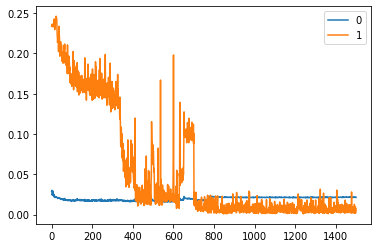

In [20]:
#pd.DataFrame([loss_train_single[-100:],loss_test_single[-100:]]).T.plot()
pd.DataFrame([loss_train_single[:],loss_test_single[:]]).T.plot()

In [42]:
#net=Net(0,41,64,10).cuda().double()
#net.load_state_dict(torch.load(r'G:\Учеба\биржа\encoder_05-07-2022_22-03-48_64_10.pth'))
#net.eval()

Net(
  (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=41, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=41, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

<AxesSubplot:>

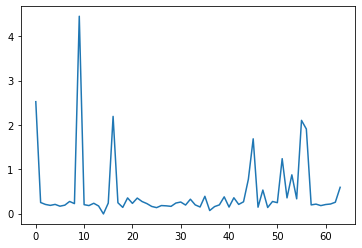

In [50]:
pd.DataFrame(net.fc7.weight.tolist()).max().plot()

In [40]:
encoder.parameters

<bound method Module.parameters of Net(
  (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=41, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=41, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)>

<AxesSubplot:>

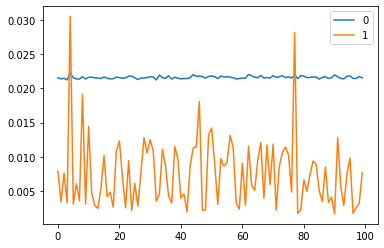

In [21]:
pd.DataFrame([loss_train_single[-100:],loss_test_single[-100:]]).T.plot()

In [67]:
np.min(loss_test_single)

0.0004612490333911201

In [68]:
loss_test_single[-1]

0.007595060523106949

In [34]:
set(net.encode(X_test)[:,1].tolist())

{0.22015705679227437,
 1.228879619132968,
 2.563102965811794,
 3.0796187129000714,
 3.57471934753508,
 3.076467791565051,
 3.090306451622155,
 6.899003949724374,
 6.67958095704833,
 7.141723973263481,
 7.484740590445284,
 7.325639384253122,
 10.94252513649613,
 11.349536642598139,
 11.568378703521176,
 11.812156589462631,
 11.220676139491303,
 12.160984424639508,
 3.5792687019979894,
 11.058922569824404,
 11.84148880232101,
 12.198355051027761,
 3.0744401529932475,
 0.2121504384678803,
 6.69797552159298,
 1.1073908294160195,
 2.5942516074818944,
 11.336932015482034,
 11.406413627323673,
 11.32101168719555,
 0.18122448633954494,
 3.592803894200501,
 3.073925346259643,
 1.111731891438063,
 7.250009391003318,
 2.5766153389484017,
 0.1362152620533124,
 0.19066200132225225,
 0.2526557995509791,
 0.20108519998842672,
 3.584732667196194,
 3.594847679398926,
 1.2150316632572873,
 1.028170145234365,
 11.811787926142815,
 11.697249137113603,
 1.2776957154565336,
 3.567694420863094,
 7.4072058291

<AxesSubplot:>

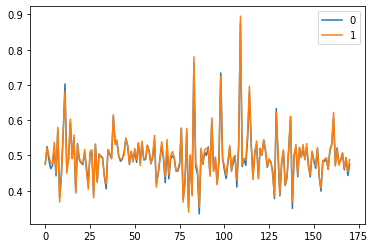

In [34]:
number=22
pd.DataFrame([net(X_test[::50])[:,number].tolist(),X_test[::50][:,number].tolist()]).T.plot()

In [25]:
loss_test=[]
loss_train=[]
epoch=700
b_size=75
drop=0.6
decay=0
lr=0.004
hidden_size=64
min_params_test=[]
min_params_train=[]
min_loss=[10000,1000]
#for epoch in range(10,20,5):
#for lr in np.arange(0.001,0.0071,0.001):
for drop in np.arange(0.0,0.16,0.05):
    #print(drop)
    #for b_size in range(50,91,20):
    for hidden_size in range(64,257,64):
        print(hidden_size)
        for test_size in np.arange(4,21,2):
            loss=train(drop, lr, b_size, epoch,0.9,hidden_size,test_size,decay=decay)
            #drop,learning_rate,batch_size,epochs,momentum,hidden_size=128,decay=0
            for i in range(epoch):
                # 0 - train, 1 - test
                if loss[0][i]<min_loss[0]:
                    min_loss[0]=loss[0][i]
                    min_params_train=[lr,drop,b_size,hidden_size,test_size,decay,i]
                if loss[1][i]<min_loss[1]:
                    min_loss[1]=loss[1][i]
                    min_params_test=[lr,drop,b_size,hidden_size,test_size,decay,i]
            loss_test.append(loss[1])
            loss_train.append(loss[0])

64
128
192


KeyboardInterrupt: 

In [26]:
loss_train_mean=[]
loss_test_mean=[]
for i in range(len(loss_test)):
    #if (np.mean(loss_test[i][1:])<0.1):
    loss_train_mean.append(np.mean(loss_train[i][1:]))
    loss_test_mean.append(np.mean(loss_test[i][1:]))

<AxesSubplot:>

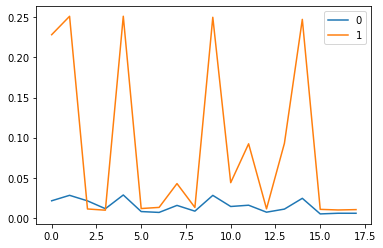

In [28]:
pd.DataFrame([loss_train_mean[:],loss_test_mean[:]]).T.plot()

In [29]:
np.min(loss_test_mean)

0.00961714932485205

In [30]:
np.min(loss_test)

0.0011589267271206653

In [31]:
min_params_test

[0.004, 0.0, 75, 64, 10, 0, 623]

In [49]:
torch.save(net.state_dict(), directory+'\\encoder_3.pth')

In [105]:
#model = torch.load(r'G:\Учеба\биржа\encoder.pth')